In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from esdc.data import ESDCData, MiniCubes
# from models.esdc_sampling import SamplingModel
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [17]:
a = np.ones((2,2))
print(a.shape, a.strides)
s0, s1 = a.strides

(2, 2) (16, 8)


In [13]:
a = np.array([[0, 5, 6, 2, 3, 6, 7, 1, 4, 8], 
              [2, 1, 3, 7, 0, 3, 5, 4, 0, 1]])
print(a.shape)
b = np.ones((5,5,5))
print(b.shape)

(2, 10)
(5, 5, 5)


In [14]:
a.strides, b.strides

((80, 8), (200, 40, 8))

## Extract ESDC Data

In [2]:
# show the low resolution datasets
!ls /media/disk/databases/BACI-CABLAB/low_res_data/

# # show the datasets for gpp
# !ls '/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity'

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: ml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_ml'
aerosol_optical_thickness_550  latent_energy
aerosol_optical_thickness_555  net_ecosystem_exchange
aerosol_optical_thickness_659  open_water_evaporation
aerosol_optical_thickness_865  ozone
air_temperature_2m	       potential_evaporation
bare_soil_evaporation	       precipitation
black_sky_albedo	       root_moisture
burnt_area		       sensible_heat
c_emissions		       snow_sublimation
country_mask		       snow_water_equivalent
evaporation		       soil_moisture
evaporative_stress	       surface_moisture
fractional_snow_cover	       terrestrial_ecosystem_respiration
gross_primary_productivity     transpiration
interception_loss	       water_mask
land_surface_temperature       water_vapour


We want to look at gross primary productivity (GPP) and land surface temperature (LST). We also want to look at the year 2010 as well as only take Europe into consideration.

In [3]:
# variables for the experiment
variables = [
    'gross_primary_productivity',
    'land_surface_temperature',
    'burnt_area'
]

resolution = 'low'
start_time = '2010'
end_time = '2010'
subsection = 'europe'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'

# Initialize data class
esdc_data = ESDCData(
    variables=variables,
    resolution=resolution,
    subsection=subsection,
)

# extract data
data = esdc_data.extract_datacube()

# Subselect Time
data = data.sel(time=slice('2010','2010'))

In [4]:
data.gross_primary_productivity

<xarray.DataArray 'gross_primary_productivity' (time: 46, lat: 144, lon: 312)>
dask.array<shape=(46, 144, 312), dtype=float32, chunksize=(46, 144, 312)>
Coordinates:
  * time          (time) datetime64[ns] 2010-01-05 2010-01-13 ... 2010-12-31
  * lon           (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat           (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
    water_mask    (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
    country_mask  (lat, lon) float64 nan nan nan nan ... 364.0 364.0 364.0 364.0
Attributes:
    url:            http://www.fluxcom.org/
    standard_name:  gross_primary_productivity_of_carbon
    units:          gC m-2 day-1
    long_name:      Gross Primary Productivity
    source_name:    GPPall
    references:     Tramontana, Gianluca, et al. "Predicting carbon dioxide a...

In [5]:
data.land_surface_temperature

<xarray.DataArray 'land_surface_temperature' (time: 46, lat: 144, lon: 312)>
dask.array<shape=(46, 144, 312), dtype=float32, chunksize=(46, 144, 312)>
Coordinates:
  * time          (time) datetime64[ns] 2010-01-05 2010-01-13 ... 2010-12-31
  * lon           (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat           (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
    water_mask    (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
    country_mask  (lat, lon) float64 nan nan nan nan ... 364.0 364.0 364.0 364.0
Attributes:
    comment:        Advanced Along Track Scanning Radiometer pixel land surfa...
    source_name:    LST
    url:            http://data.globtemperature.info/
    standard_name:  surface_temperature
    units:          K
    long_name:      land surface temperature

### Plot Data (Preliminary View)

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


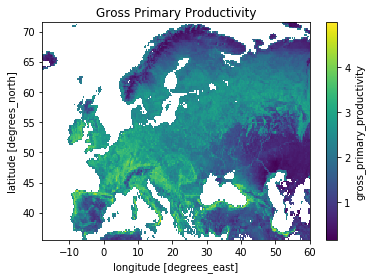

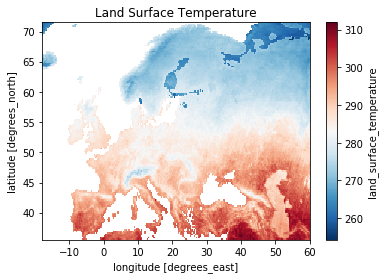

In [18]:
fig, ax = plt.subplots()

data.gross_primary_productivity.mean(dim='time', skipna=True).plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

fig, ax = plt.subplots()

data.land_surface_temperature.mean(dim='time', skipna=True).plot.imshow(ax=ax, cmap='RdBu_r', robust=False)
ax.set_title('Land Surface Temperature')
plt.show()

## Extract MiniCubes

#### Save MiniCubes

In [17]:
spatial_window = 5
save_name = 'sakame'
minicuber = MiniCubes(spatial_res=spatial_window, save_name=save_name)

In [18]:
X_lst, y_lst = minicuber.get_spatial_cubes(data.land_surface_temperature)

100%|██████████| 46/46 [40:30<00:00, 45.36s/it]


In [20]:
X_lst.shape, y_lst.shape

((740540, 24), (740540, 4))

In [19]:
X_gpp, y_gpp = minicuber.get_spatial_cubes(data.gross_primary_productivity)

100%|██████████| 46/46 [54:11<00:00, 70.48s/it]


In [21]:
X_gpp.shape, y_gpp.shape

((987804, 24), (987804, 4))

## Wildfires - Minicubes (3 x 3 x 3)

In [30]:
# variables for the experiment
variables = [
#     'land_surface_temperature',
#     'root_moisture',
    'burnt_area'
]

resolution = 'low'
start_time = '2002'
end_time = '2010'
subsection = 'europe'
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'

# Initialize data class
esdc_data = ESDCData(
    variables=variables,
    resolution=resolution,
    subsection=subsection,
)

# extract data
data = esdc_data.extract_datacube()

# # Subselect Time
# data = data.sel(time=slice(start_time, end_time))

In [31]:
data

<xarray.Dataset>
Dimensions:       (bnds: 2, lat: 144, lon: 312, time: 506)
Coordinates:
  * lon           (lon) float32 -17.875 -17.625 -17.375 ... 59.375 59.625 59.875
  * lat           (lat) float32 71.375 71.125 70.875 ... 36.125 35.875 35.625
  * time          (time) datetime64[ns] 2001-01-05 2001-01-13 ... 2011-12-31
    water_mask    (lat, lon) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0 1.0
    country_mask  (lat, lon) float64 nan nan nan nan ... 364.0 364.0 364.0 364.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<shape=(506, 2), chunksize=(46, 2)>
    lon_bnds      (time, lon, bnds) float32 dask.array<shape=(506, 312, 2), chunksize=(46, 312, 2)>
    lat_bnds      (time, lat, bnds) float32 dask.array<shape=(506, 144, 2), chunksize=(46, 144, 2)>
    burnt_area    (time, lat, lon) float32 dask.array<shape=(506, 144, 312), chunksize=(46, 144, 312)>
Attributes:
    Conventions:  CF-1.6
    institution:  Brockmann 

In [ ]:
spatial_res = 3
temporal_res = 3

In [ ]:
# variables for the experiment
save_name = 'wildfires'
start_time = '2002'
end_time = '2011'
subsection = 'europe'
data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'

# Save Minicubes
temporal_res = [
#     2, 
    3, 
#     4, 
#     5, 
#     6, 
#     7, 
#     8, 
#     9, 
#     10
]

variables = [
#     'gross_primary_productivity',
    'land_surface_temperature',
#     'air_temperature_2m',
#     'precipitation',
#     'evaporation',
#     'soil_moisture',
    'root_moisture',
    'burnt_area',
#     'latent_energy',
#     'net_ecosystem_exchange',
#     'potential_evaporation',
#     'sensible_heat',
#     'terrestrial_ecosystem_respiration',
#     'transpiration',
#     'water_vapour'
]

# for ivariable in variables:
# for iwindow in temporal_res:

for ivariable in variables:
    print(ivariable)
    # Initialize data class
    esdc_data = ESDCData(
        variables=ivariable,
        resolution=resolution,
        subsection=subsection,
    )

    # extract data
    data = esdc_data.extract_datacube()
    
    # Initialize data class
    minicuber = MiniCubes(
        time_stamp = 'end',
        spatial_res=3,
        temporal_res=3, 
        save_name='wildfires'
    )

    # Save Minicubes
    X, y = minicuber.get_spatemp_cubes(data[ivariable])
    print(X.shape, y.shape)
    del X
    del y

land_surface_temperature


## Save MiniCubes

In [5]:
%%time

# Save Minicubes
window_size = 15
save_name = f'experiment_{window_size}.h5'

esdc_data.save_minicubes(save_name=save_name, window_size=window_size)

No data fitted...extracting datacube
/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity
CPU times: user 1min 9s, sys: 2min 46s, total: 3min 56s
Wall time: 1min 3s


## Load MiniCubes

In [27]:
%%time
save_name = f'experiment_{window_size}.h5'
save_name = 'nbexp_11.h5'
dat = esdc_data.load_minicubes(save_name=save_name)

print(dat['gross_primary_productivity']['2010-06-06T00:00:00.000000000']['x'].shape)

(15378, 120)
CPU times: user 23.9 ms, sys: 26.6 ms, total: 50.5 ms
Wall time: 49.1 ms


## Save MiniCubes

In [1]:
minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'

In [3]:
%%time

# Save Minicubes
window_sizes = [
    2, 
    3, 
    4, 
    5, 
    6, 
    7, 
    8, 
    9, 
    10
]

variables = [
    'gross_primary_productivity',
    'land_surface_temperature',
#     'air_temperature_2m',
#     'precipitation',
#     'evaporation',
#     'soil_moisture',
#     'surface_moisture',
#     'latent_energy',
#     'net_ecosystem_exchange',
#     'potential_evaporation',
#     'sensible_heat',
#     'terrestrial_ecosystem_respiration',
#     'transpiration',
#     'water_vapour'
]

# for ivariable in variables:
for iwindow in window_sizes:
    print(f"Windowsize: {iwindow}")
    # variables for the experiment
    start_time = '2010-06'
    end_time = '2010-08'
    subsection = 'europe'
    data_path = '/media/disk/databases/BACI-CABLAB/low_res_data/'
    minicube_path = '/home/emmanuel/projects/2019_sakame/data/processed/nb_data/'

    # Initialize data class
    esdc_data = ESDCData(
        variables=variables,
        time_frame=[start_time, end_time],
        subsection=subsection,
        minicube_path=minicube_path

    )

    # extract data
    data = esdc_data.extract_datacube()

    # Save Minicubes
    save_name = f'summer_{iwindow}.h5'
    esdc_data.save_minicubes(save_name=save_name, window_size=iwindow)

Windowsize: 2
Windowsize: 3
Windowsize: 4
Windowsize: 5
Windowsize: 6
Windowsize: 7
Windowsize: 8
Windowsize: 9
Windowsize: 10
CPU times: user 15min 2s, sys: 15min 39s, total: 30min 41s
Wall time: 17min 53s
